In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display
from sklearn.decomposition import PCA
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
#データ読み込み
train = pd.read_csv("titanic/train.csv")
test = pd.read_csv("titanic/test.csv")

In [3]:
#データ表示
print(train.head())
print(test.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  
  

In [4]:
# Pclass, Age, Fareのみ抽出　⇒　カテゴリ変数をOne-Hotエンコーディング

#train1, test1 → PCAに回さない変数
#train2, test2 → PCAに回して次元削減を図る変数
###
train1 = train.copy().drop(["Pclass", "Age", "Fare"], axis=1, inplace=True)
train2 = train.copy().drop(["PassengerId", "Name", "Ticket", "Cabin", "Survived", "SibSp", "Parch", "Sex", "Embarked"], axis=1)

test1 = test.copy().drop(["Pclass", "Age", "Fare"], axis=1, inplace=True)
test2 = test.copy().drop(["PassengerId", "Name", "Ticket", "Cabin", "SibSp", "Parch", "Sex", "Embarked"], axis=1)
###

#後々のテーブル結合のために、インデックス列振り直し
###
train1 = train.reset_index()
print(train1.head())

test1 = test.reset_index()
print(test1.head())
###

###
print(train2.head())
print(train2.shape)

print(test2.head())
print(test2.shape)

   index  PassengerId  Survived  Pclass  \
0      0            1         0       3   
1      1            2         1       1   
2      2            3         1       3   
3      3            4         1       1   
4      4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0     

In [5]:
#欠損値について
print(train2.isnull().sum())
print(test2.isnull().sum())

Pclass      0
Age       177
Fare        0
dtype: int64
Pclass     0
Age       86
Fare       1
dtype: int64


AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


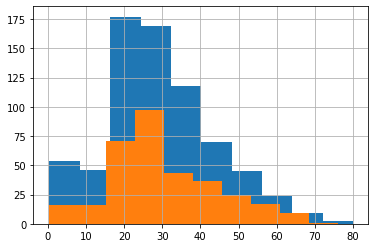

In [6]:
# [age]の欠損値をどう埋めるか
#とりあえずヒストグラム
print(train["Age"].hist())
print(test["Age"].hist())

In [7]:
#平均値か中央値で埋めるのがよさそう？
print(train2['Age'].describe())
print(test2['Age'].describe())

train2['Age'].fillna(train2['Age'].mean(), inplace=True)
test2['Age'].fillna(test2['Age'].mean(), inplace=True)
test2['Fare'].fillna(test2['Fare'].median(), inplace=True)

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64
count    332.000000
mean      30.272590
std       14.181209
min        0.170000
25%       21.000000
50%       27.000000
75%       39.000000
max       76.000000
Name: Age, dtype: float64


In [8]:
#相関係数
print(train2.corr())
print(test2.corr())

          Pclass       Age      Fare
Pclass  1.000000 -0.331339 -0.549500
Age    -0.331339  1.000000  0.091566
Fare   -0.549500  0.091566  1.000000
          Pclass       Age      Fare
Pclass  1.000000 -0.440782 -0.577313
Age    -0.440782  1.000000  0.324568
Fare   -0.577313  0.324568  1.000000


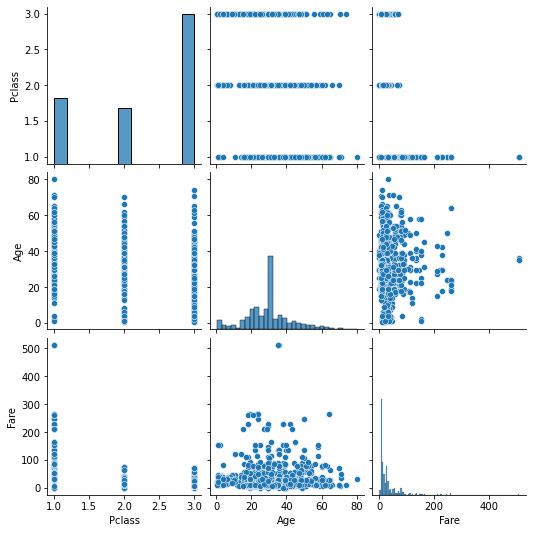

In [9]:
#相関係数グラフ化
sns.pairplot(train2)
plt.show()

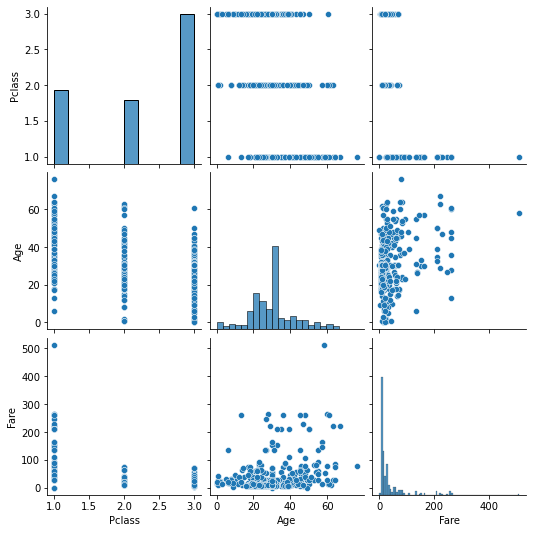

In [10]:
sns.pairplot(test2)
plt.show()

In [11]:
#各変数の単位系を揃える・PCAのため、変数を標準化
from sklearn.preprocessing import StandardScaler

std_sc = StandardScaler()
std_sc.fit(train2)
std_train = std_sc.transform(train2)
std_train_df = pd.DataFrame(std_train, columns = train2.columns)
display(std_train_df)

std_sc.fit(test2)
std_test = std_sc.transform(test2)
std_test_df = pd.DataFrame(std_test, columns = test2.columns)
display(std_test_df)

,Pclass,Age,Fare
0,0.827377,-0.592481,-0.502445
1,-1.566107,0.638789,0.786845
2,0.827377,-0.284663,-0.488854
3,-1.566107,0.407926,0.420730
4,0.827377,0.407926,-0.486337
...,...,...,...
886,-0.369365,-0.207709,-0.386671
887,-1.566107,-0.823344,-0.044381
888,0.827377,0.000000,-0.176263
889,-1.566107,-0.284663,-0.044381


,Pclass,Age,Fare
0,0.873482,0.334993,-0.497413
1,0.873482,1.325530,-0.512278
2,-0.315819,2.514175,-0.464100
3,0.873482,-0.259330,-0.482475
4,0.873482,-0.655545,-0.417492
...,...,...,...
413,0.873482,0.000000,-0.493455
414,-1.505120,0.691586,1.314435
415,0.873482,0.651965,-0.507796
416,0.873482,0.000000,-0.493455


In [12]:
pca = PCA()
pca.fit(std_train_df)
pca.fit(std_test_df)

# データを主成分空間に写像
pca_cor_train = pca.transform(std_train_df)
pca_cor_test = pca.transform(std_test_df)

In [13]:
# 固有ベクトルのマトリックス表示
eig_vec_train = pd.DataFrame(pca.components_.T, index = train2.columns, \
                          columns = ["PC{}".format(x + 1) for x in range(len(std_train_df.columns))])
display(eig_vec_train)

eig_vec_test = pd.DataFrame(pca.components_.T, index = test2.columns, \
                          columns = ["PC{}".format(x + 1) for x in range(len(std_test_df.columns))])
display(eig_vec_test)

,PC1,PC2,PC3
Pclass,-0.625738,-0.180368,0.758894
Age,0.515678,-0.825621,0.228970
Fare,0.585260,0.534619,0.609634


,PC1,PC2,PC3
Pclass,-0.625738,-0.180368,0.758894
Age,0.515678,-0.825621,0.228970
Fare,0.585260,0.534619,0.609634


In [14]:
# 固有値
eig_train = pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(std_train_df.columns))], columns=['固有値']).T
display(eig_train)

eig_test = pd.DataFrame(pca.explained_variance_, index=["PC{}".format(x + 1) for x in range(len(std_test_df.columns))], columns=['固有値']).T
display(eig_test)

,PC1,PC2,PC3
固有値,1.907785,0.695199,0.40421


,PC1,PC2,PC3
固有値,1.907785,0.695199,0.40421


In [15]:
dv_train = np.sqrt(eig_train)
dv_train = dv_train.rename(index = {'固有値':'主成分の標準偏差'})
display(dv_train)

dv_test = np.sqrt(eig_test)
dv_test = dv_test.rename(index = {'固有値':'主成分の標準偏差'})
display(dv_test)

,PC1,PC2,PC3
主成分の標準偏差,1.381226,0.833786,0.635775


,PC1,PC2,PC3
主成分の標準偏差,1.381226,0.833786,0.635775


In [16]:
# 寄与率
ev_train = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(std_train_df.columns))], columns=['寄与率']).T
display(ev_train)

ev_test = pd.DataFrame(pca.explained_variance_ratio_, index=["PC{}".format(x + 1) for x in range(len(std_test_df.columns))], columns=['寄与率']).T
display(ev_test)

,PC1,PC2,PC3
寄与率,0.634407,0.231179,0.134414


,PC1,PC2,PC3
寄与率,0.634407,0.231179,0.134414


In [17]:
# 累積寄与率
t_ev_train = pd.DataFrame(pca.explained_variance_ratio_.cumsum(), index=["PC{}".format(x + 1) for x in range(len(std_train_df.columns))], columns=['累積寄与率']).T
display(t_ev_train)

t_ev_test = pd.DataFrame(pca.explained_variance_ratio_.cumsum(), index=["PC{}".format(x + 1) for x in range(len(std_test_df.columns))], columns=['累積寄与率']).T
display(t_ev_test)

,PC1,PC2,PC3
累積寄与率,0.634407,0.865586,1.0


,PC1,PC2,PC3
累積寄与率,0.634407,0.865586,1.0


In [18]:
print('主成分得点')
cor_train = pd.DataFrame(pca_cor_train, columns=["PC{}".format(x + 1) for x in range(len(std_train_df.columns))])
display(cor_train)

cor_test = pd.DataFrame(pca_cor_test, columns=["PC{}".format(x + 1) for x in range(len(std_test_df.columns))])
display(cor_test)

主成分得点


,PC1,PC2,PC3
0,-1.117311,0.071315,0.185924
1,1.769890,0.175740,-0.562558
2,-0.950622,-0.175559,0.264690
3,1.436567,0.170613,-0.838615
4,-0.591997,-0.746030,0.424806
...,...,...,...
886,-0.102288,0.031389,-0.563595
887,0.529418,0.938518,-1.404086
888,-0.620881,-0.243466,0.520436
889,0.807203,0.493772,-1.280744


,PC1,PC2,PC3
0,-0.664938,-0.700052,0.436343
1,-0.162840,-1.525807,0.654084
2,1.222504,-2.266909,0.053065
3,-0.962674,-0.201380,0.309368
4,-1.128961,0.160485,0.258263
...,...,...,...
413,-0.835370,-0.421359,0.362053
414,2.067732,0.403210,-0.182551
415,-0.507560,-0.967301,0.502590
416,-0.835370,-0.421359,0.362053


In [19]:
cor_train1 = cor_train.reset_index()
train3 = pd.merge(train1, cor_train1, on='index', how='right')
train3.head()

cor_test1 = cor_test.reset_index()
test3 = pd.merge(test1, cor_test1, on='index', how='right')
test3.head()

,index,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,PC1,PC2,PC3
0,0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,-0.664938,-0.700052,0.436343
1,1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,-0.162840,-1.525807,0.654084
2,2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,1.222504,-2.266909,0.053065
3,3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,-0.962674,-0.201380,0.309368
4,4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,-1.128961,0.160485,0.258263


In [20]:
#テストデータも同様に前処理？→あとは前回やったLgbmの手順
#要は、Age, Sex, Fareを2次元にまとめてからLgbmしてみたってこと

In [21]:
#不要な列を削除
#train3.drop(["index", "PassengerId", "Name", "Ticket", "Age", "Pclass", "Fare", "PC3", "Cabin"], axis=1, inplace=True)
train3['Families'] = train3['SibSp'] * train3['Parch']
train3['PC1'] = train3['PC1']**2
train3['PC2'] = train3['PC2']**2
#train3 = pd.get_dummies(train3, columns=['Embarked'])
#train3['Embarked_C'] = ((train3['PC1'] + train3['PC2'])**2)*3
#train3['Embarked_Q'] = ((train3['PC1'] + train3['PC2'])**2)*2
#train3['Embarked_S'] = ((train3['PC1'] + train3['PC2'])**2)*1


train3.drop(["Embarked", "index", "PassengerId", "Name", "Ticket", "Age", "Pclass", "Fare", "PC3", "Cabin", "SibSp", "Parch"], axis=1, inplace = True)

#test3.drop(["index", "PassengerId", "Name", "Ticket", "Age", "Pclass", "Fare", "PC3", "Cabin"], axis=1, inplace=True)
test3['Families'] = test3['SibSp'] * test3['Parch']
test3['PC1'] = test3['PC1']**2
test3['PC2'] = test3['PC2']**2
#test3 = pd.get_dummies(test3, columns=['Embarked'])
#test3['Embarked_C'] = ((test3['PC1'] + test3['PC2'])**2)*3
#test3['Embarked_Q'] = ((test3['PC1'] + test3['PC2'])**2)*2
#test3['Embarked_S'] = ((test3['PC1'] + test3['PC2'])**2)*1

test3.drop(["Embarked", "index", "PassengerId", "Name", "Ticket", "Age", "Pclass", "Fare", "PC3", "Cabin", "SibSp", "Parch"], axis=1, inplace=True)

In [22]:
train3.head(10)

,Survived,Sex,PC1,PC2,Families
0,0,male,1.248384,0.005086,0
1,1,female,3.132511,0.030885,0
2,1,female,0.903683,0.030821,0
3,1,female,2.063724,0.029109,0
4,0,male,0.350460,0.556560,0
5,0,male,0.636076,0.163897,0
6,0,male,4.734859,1.102237,0
7,0,male,3.055747,2.222590,3
8,1,female,0.762359,0.041844,0
9,1,female,0.173899,1.083893,0


In [23]:
#train4 = train3[['Survived', 'PC1', 'PC2', 'Embarked_C', 'Embarked_Q', 'Embarked_S']]
#train4.corr()

In [24]:
#以下、Lgbm手順
label = train["Survived"]
train3.drop(["Survived"], axis=1, inplace=True)

In [25]:
train3.shape
train3.dtypes

Sex          object
PC1         float64
PC2         float64
Families      int64
dtype: object

In [26]:
#カテゴリ変数のタイプ変換
cat_feat = ["Sex"]
for i in cat_feat :
    train3[i] = train3[i].astype("category")
    test3[i] = test3[i].astype("category")

In [27]:
X_train3, X_valid, y_train3, y_valid = train_test_split(train3, label)

In [28]:
lgb_train3 = lgb.Dataset(X_train3, y_train3, categorical_feature=cat_feat)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train3, categorical_feature=cat_feat)

params = {
    "max_depth": 6, 
    "num_iterations": 1000, 
    "boosting_type": "gbdt", 
    "learning_rate": 0.001, 
    "num_leaves": 60, 
    "objective" : "binary",
    "metric" : "binary_logloss",
    #"early_stopping_round" : 10
}

In [29]:
model = lgb.train(params, lgb_train3, valid_sets=[lgb_train3, lgb_eval])

C:\Users\watch\anaconda3\lib\site-packages\lightgbm\engine.py:177: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
C:\Users\watch\anaconda3\lib\site-packages\lightgbm\basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')
C:\Users\watch\anaconda3\lib\site-packages\lightgbm\basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
C:\Users\watch\anaconda3\lib\site-packages\lightgbm\basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Info] Number of positive: 267, number of negative: 401
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 459
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 4
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.399701 -> initscore=-0.406713
[LightGBM] [Info] Start training from score -0.406713
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	training's binary_logloss: 0.672471	valid_1's binary_logloss: 0.646753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	training's binary_logloss: 0.672052	valid_1's binary_logloss: 0.646392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	training's binary_logloss: 0.671635	valid_1's binary_logloss: 0.646033
[LightGBM] [Warning] No further splits with positive gain, be

In [30]:
val_pred = model.predict(X_valid, num_iteration=model.best_iteration)
val_pred

array([0.31590068, 0.20441227, 0.29646299, 0.51935963, 0.23889996,
       0.34606131, 0.25893199, 0.71774916, 0.30726219, 0.31643934,
       0.23889996, 0.1872401 , 0.76200941, 0.32707745, 0.18206665,
       0.58138195, 0.68513265, 0.23889996, 0.32399194, 0.39631   ,
       0.52520062, 0.55174678, 0.71230355, 0.1872401 , 0.35424545,
       0.35529244, 0.23029715, 0.23358936, 0.34606131, 0.29577516,
       0.35424545, 0.23889996, 0.21089656, 0.29964942, 0.29648762,
       0.26530631, 0.78834954, 0.18583754, 0.67203215, 0.20500166,
       0.21089656, 0.18002776, 0.37826087, 0.5456854 , 0.63231679,
       0.25493683, 0.15849838, 0.29577516, 0.22702702, 0.66638438,
       0.76200941, 0.25584023, 0.27106578, 0.18583754, 0.31590068,
       0.23889996, 0.78587223, 0.26678557, 0.21089656, 0.31643934,
       0.67529709, 0.52339362, 0.25893199, 0.76200941, 0.70416033,
       0.32399194, 0.17847212, 0.23358936, 0.23358936, 0.18277199,
       0.29577516, 0.58138195, 0.25893199, 0.68387812, 0.35292

In [31]:
val_pred = np.where(val_pred < 0.5, 0, 1)
acc = accuracy_score(y_valid, val_pred)
acc

0.8026905829596412

In [32]:
importance = pd.DataFrame(model.feature_importance(), index=train3.columns, columns=['importance'])
display(importance)

,importance
Sex,1000
PC1,7381
PC2,8604
Families,2324


In [33]:
#ゲイン
importance = pd.DataFrame(model.feature_importance(importance_type='gain'), index=train3.columns, columns=['importance'])
importance = importance.sort_values('importance', ascending=False)
display(importance)

,importance
Sex,87007.019896
PC1,17864.571204
Families,14146.876044
PC2,13515.137796


In [34]:
test_pred = model.predict(test3, num_iteration=model.best_iteration)
test_pred = np.where(test_pred < 0.5, 0, 1)
test_pred

array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [35]:
sub = pd.read_csv("titanic/gender_submission.csv")

In [36]:
sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [37]:
sub["Survived"] = test_pred
sub

sub.to_csv("C:/Users/watch/titanic/submission.csv", index=False)

In [38]:
!git init

Reinitialized existing Git repository in C:/Users/watch/.git/


In [44]:
!git add "/Users/watch/Kaggle_Lgbm_2.ipynb"

In [ ]:
!git status